## Packages and formatting

In [1]:
#load libraries
library(tidyverse)
library(fpp3)
library(lubridate)
options(readr.show_col_types = FALSE)
options(repr.plot.width = 12, repr.plot.height = 6)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ──────────────────────────────────────────── fpp3 1.0.2 ──

✔ tsibble     1.1.6     ✔ feasts      0.4.2
✔ tsibbledata 0.4.1     ✔ fable       0.4.1

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks ba

## Load data

In [2]:
# Load the CSVs
calendar_raw <- read_csv("calendar_afcs2025.csv", show_col_types = FALSE)
prices_raw   <- read_csv("sell_prices_afcs2025.csv", show_col_types = FALSE)
train_raw    <- read_csv("sales_train_validation_afcs2025.csv", show_col_types = FALSE)
val_raw      <- read_csv("sales_test_validation_afcs2025.csv", show_col_types = FALSE)


## Clean data

In [3]:
# Clean Calendar
calendar <- calendar_raw |>
  mutate(date = mdy(date)) |>
  arrange(date) |>
  mutate(d = paste0("d_", row_number())) |>
  select(d, date, wm_yr_wk, snap_TX, event_name_1, event_name_2)


# Function to combine sales series with calendar and price series

process_data <- function(raw_df, calendar_df, prices_df) {

  df_long <- raw_df |>
    mutate(item_id = sub("_TX_3_.*", "", id), 
           store_id = "TX_3") |>
    select(-id) |>
    pivot_longer(
      cols = starts_with("d_"), 
      names_to = "d", 
      values_to = "sales"
    )
  
  df_joined <- df_long |>
    left_join(calendar_df, by = "d") |>
    left_join(prices_df, by = c("store_id", "item_id", "wm_yr_wk"))
  
  df_ts <- df_joined |>
    as_tsibble(key = item_id, index = date) |>
    mutate(
      is_event = if_else(!is.na(event_name_1), 1, 0),
    )
  
  return(df_ts)
}

train_ts <- process_data(train_raw, calendar, prices_raw)
val_ts <- process_data(val_raw, calendar, prices_raw)


# EDA

Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 27 rows containing missing values or values outside the scale range
(`geom_line()`)."


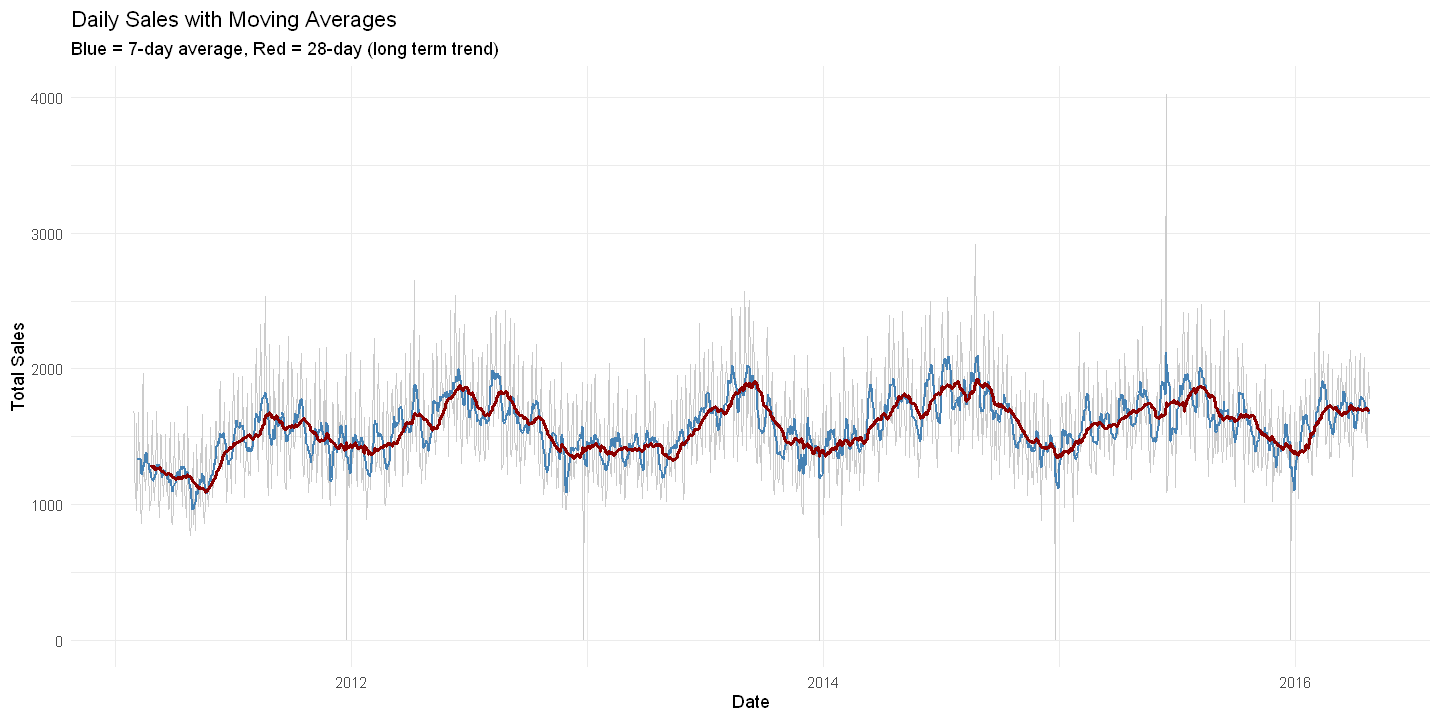

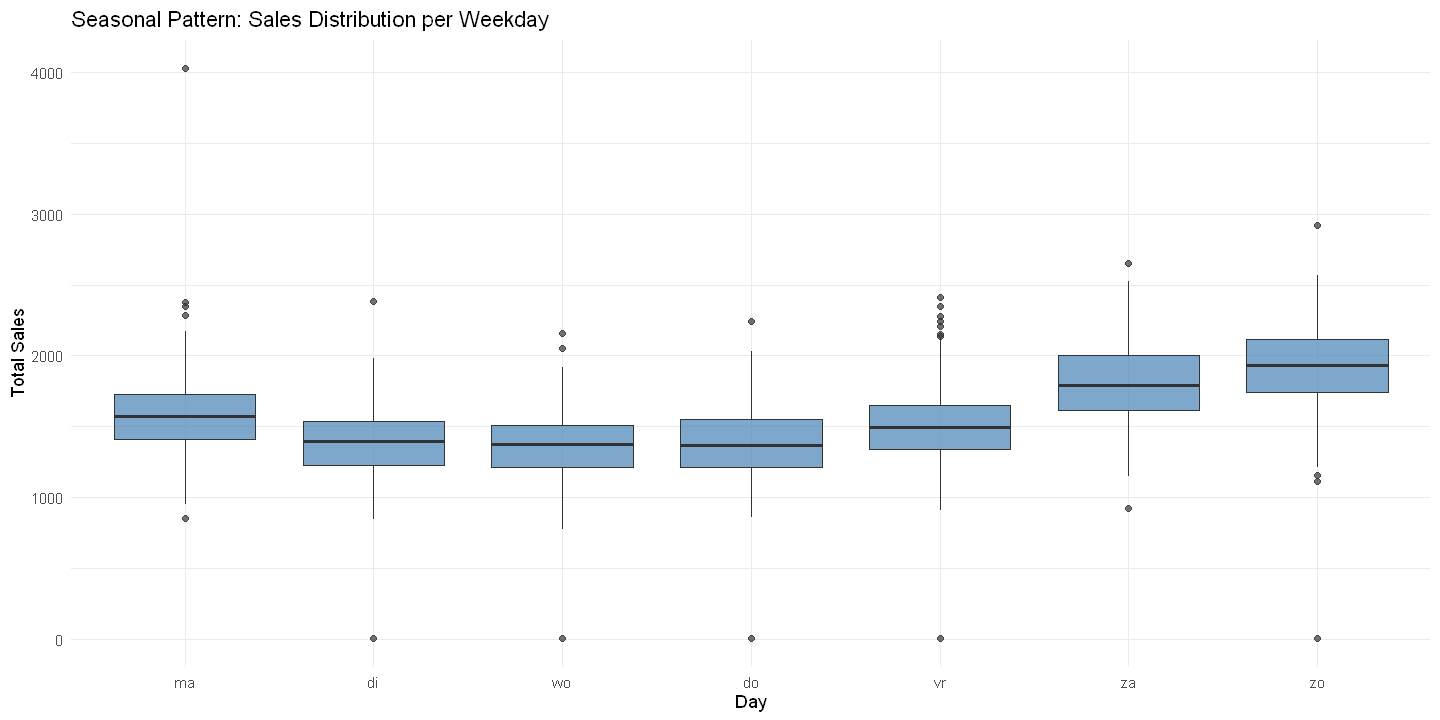

Warning message:
"`gg_season()` was deprecated in feasts 0.4.2.
ℹ Please use `ggtime::gg_season()` instead."


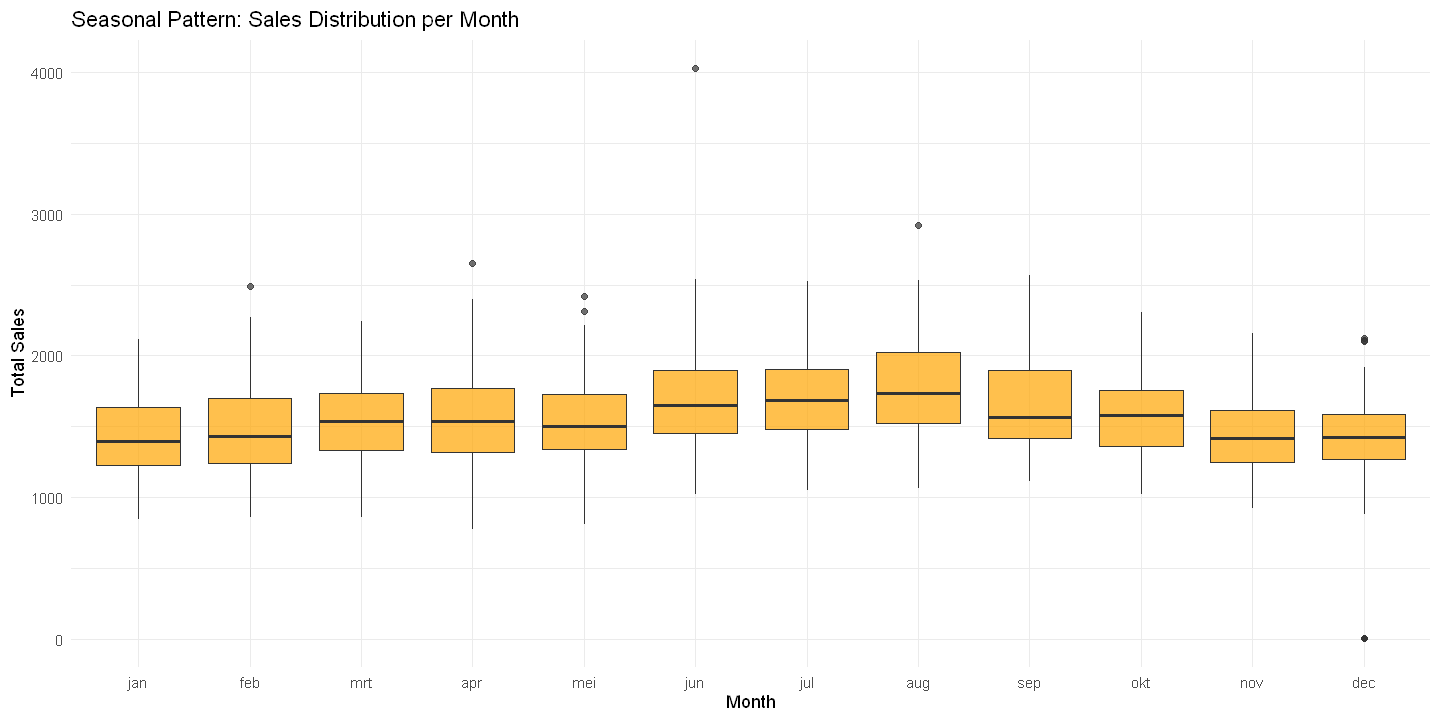

Warning message:
"`gg_subseries()` was deprecated in feasts 0.4.2.
ℹ Please use `ggtime::gg_subseries()` instead."


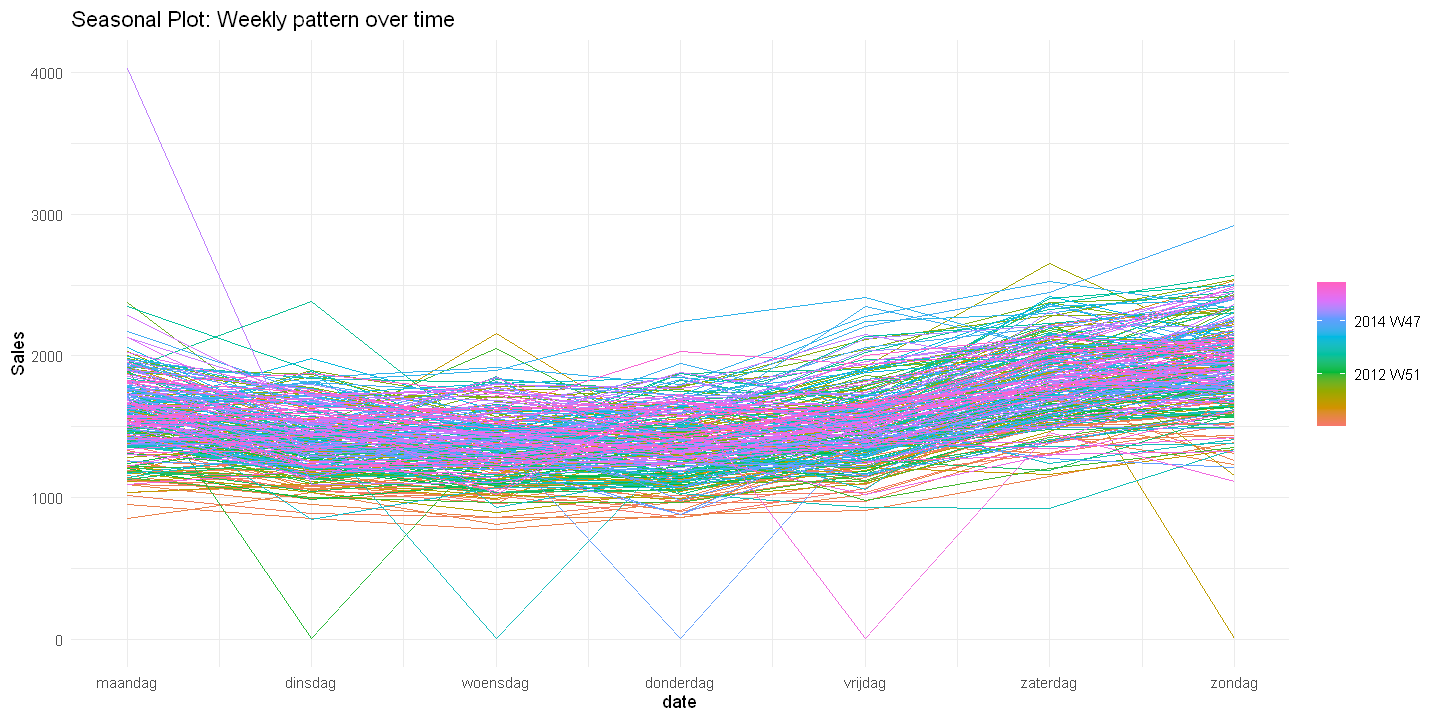

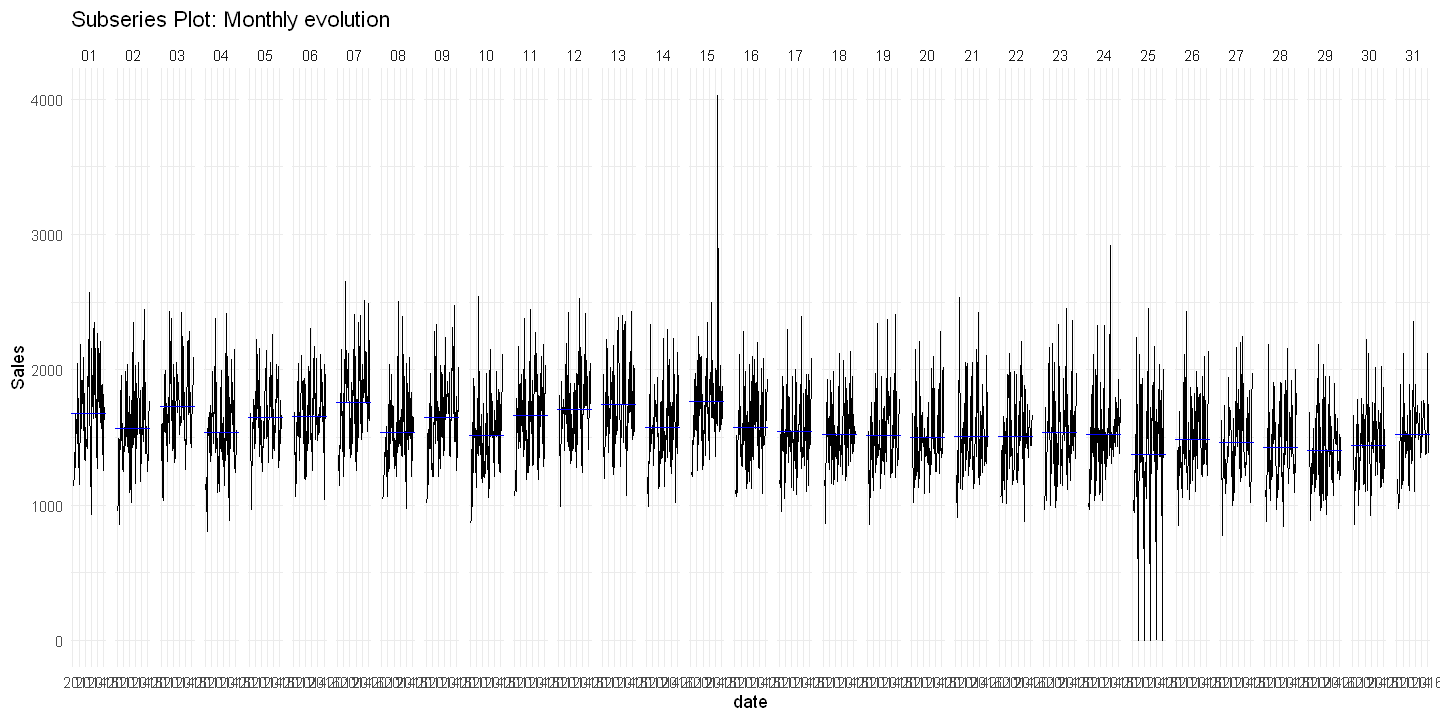

# A tibble: 1 × 6
  Mean_Sales Median_Sales Min_Sales Max_Sales SD_Sales Total_Days
       <dbl>        <dbl>     <dbl>     <dbl>    <dbl>      <int>
1      1567.         1529         1      4027     342.       1913


Warning message:
"There were 179 warnings in `summarise()`.
The first warning was:
ℹ In argument: `correlation = cor(sales, sell_price, use = "complete.obs")`.
ℹ In group 6: `item_id = "FOODS_3_006"`.
Caused by warning in `cor()`:
! the standard deviation is zero
ℹ Run `dplyr::last_dplyr_warnings()` to see the 178 remaining warnings."
Warning message:
"Removed 179 rows containing non-finite outside the scale range (`stat_bin()`)."


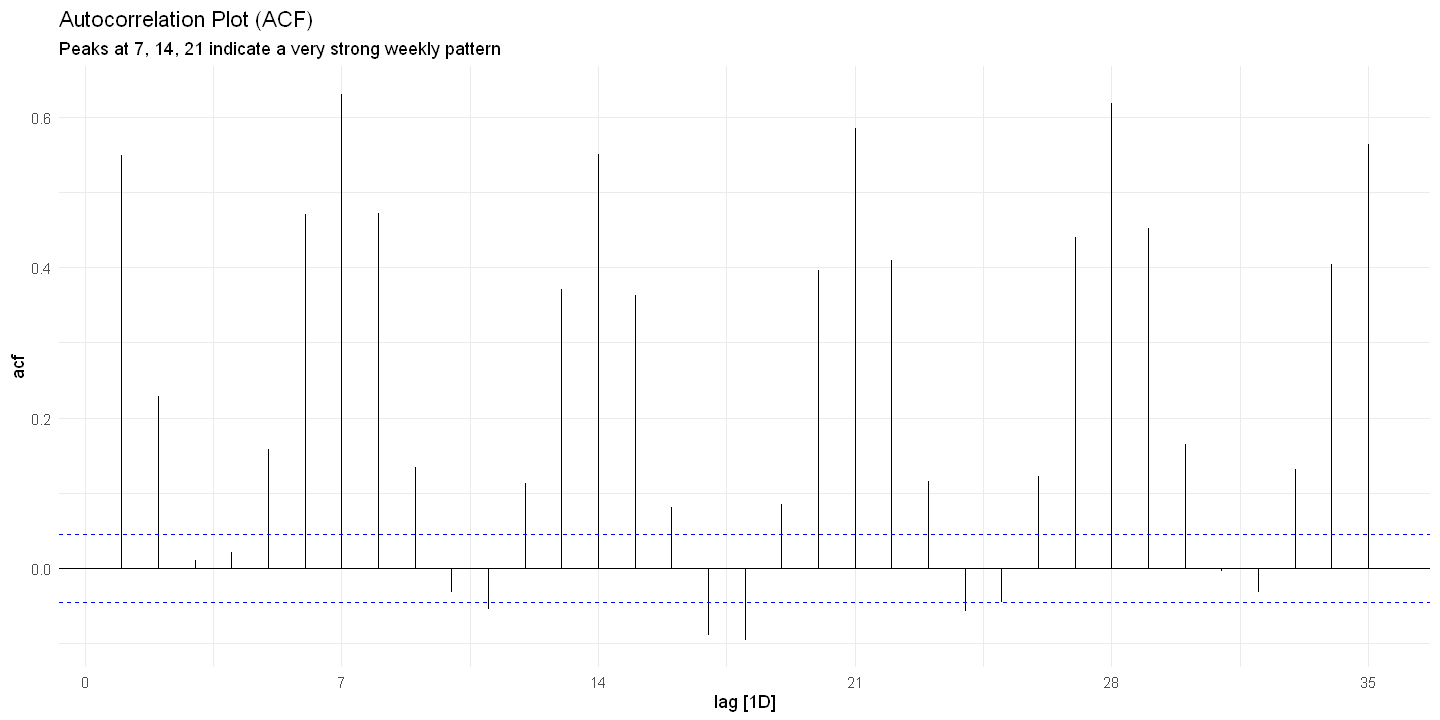

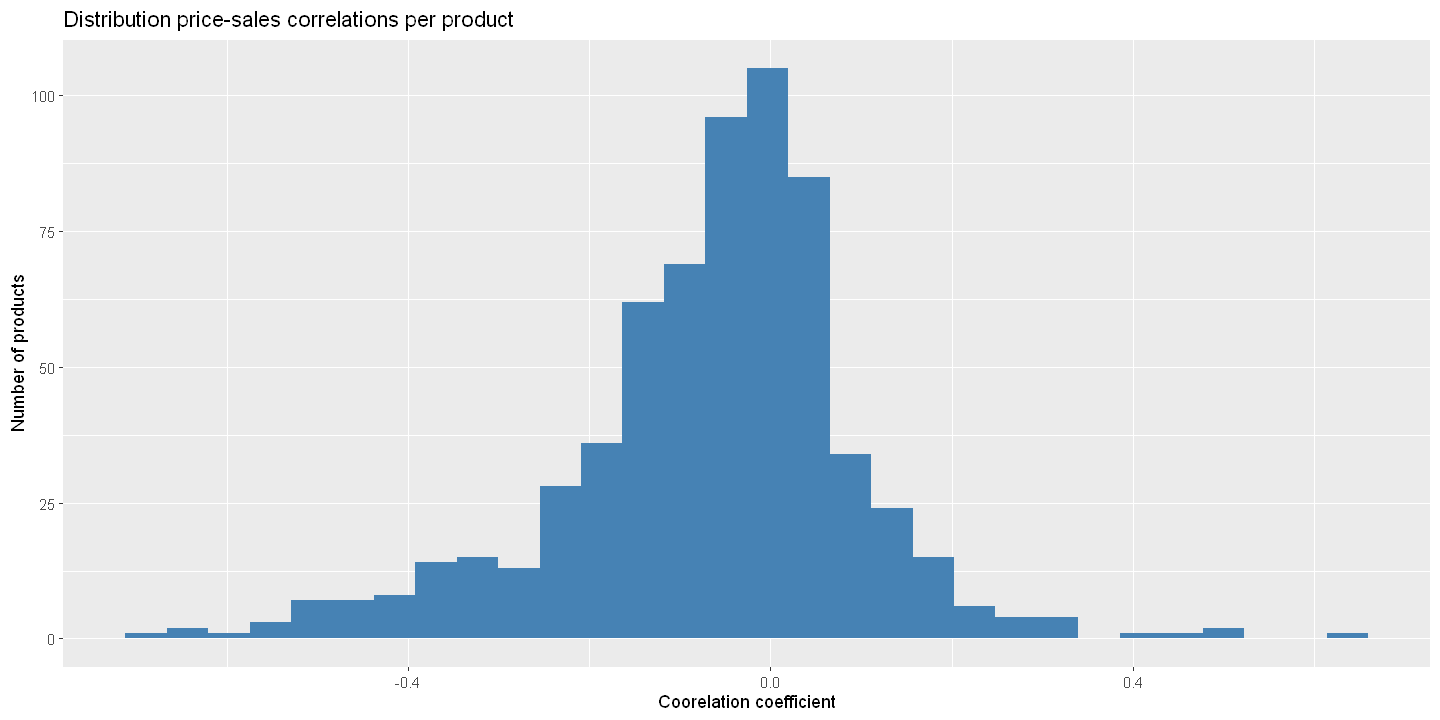

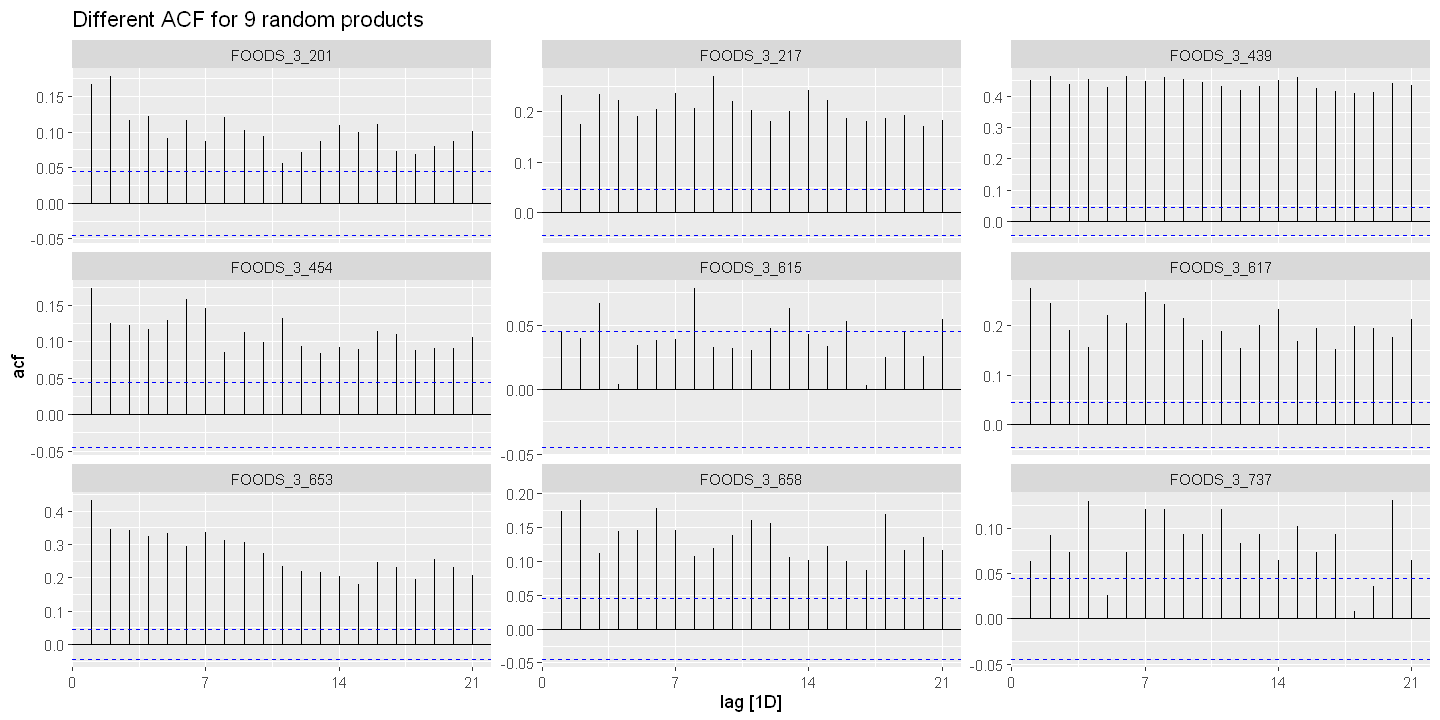

In [4]:
ts_data <- train_ts

# Aggregate sales for all products in store TX3 per day.
total_sales_tx3 <- ts_data |>
  index_by(date) |>
  summarise(total_sales = sum(sales, na.rm = TRUE)) |>
  fill_gaps(total_sales = 0) 


# 4. EXPLORATORY DATA ANALYSIS (EDA)

# A. General Trend (Moving Averages)
total_sales_tx3 |>
  mutate(
    MA_7 = slider::slide_dbl(total_sales, mean, .before = 6, .complete = TRUE),
    MA_28 = slider::slide_dbl(total_sales, mean, .before = 27, .complete = TRUE)
  ) |>
  autoplot(total_sales, color="gray80") + # Raw data in light gray
  geom_line(aes(y = MA_7), color = "steelblue", linewidth = 0.8) +
  geom_line(aes(y = MA_28), color = "darkred", linewidth = 1) +
  labs(title = "Daily Sales with Moving Averages",
       subtitle = "Blue = 7-day average, Red = 28-day (long term trend)",
       y = "Total Sales", x = "Date") +
  theme_minimal()

# B. Seasonality (Boxplots)
# Day of the week pattern
total_sales_tx3 |>
  mutate(day_name = wday(date, label = TRUE, week_start = 1)) |> 
  ggplot(aes(x = day_name, y = total_sales)) +
  geom_boxplot(fill = "steelblue", alpha = 0.7) +
  labs(title = "Seasonal Pattern: Sales Distribution per Weekday",
       x = "Day", y = "Total Sales") +
  theme_minimal()

# Month of the year pattern
total_sales_tx3 |>
  mutate(month_name = month(date, label = TRUE)) |>
  ggplot(aes(x = month_name, y = total_sales)) +
  geom_boxplot(fill = "orange", alpha = 0.7) +
  labs(title = "Seasonal Pattern: Sales Distribution per Month",
       x = "Month", y = "Total Sales") +
  theme_minimal()

# How the weekly pattern behaves over the years
total_sales_tx3 |>
  gg_season(total_sales, period = "week") +
  labs(title = "Seasonal Plot: Weekly pattern over time",
       y = "Sales") +
  theme_minimal()

# How sales evolve per month over the years (Subseries)
total_sales_tx3 |>
  gg_subseries(total_sales, period = "month") +
  labs(title = "Subseries Plot: Monthly evolution",
       y = "Sales") +
  theme_minimal()


# ACF
total_sales_tx3 |>
  ACF(total_sales, lag_max = 35) |>
  autoplot() +
  labs(title = "Autocorrelation Plot (ACF)",
       subtitle = "Peaks at 7, 14, 21 indicate a very strong weekly pattern") +
  theme_minimal()


# summary statistics 
summary_stats <- total_sales_tx3 |>
  as_tibble() |>
  summarise(
    Mean_Sales = mean(total_sales),
    Median_Sales = median(total_sales),
    Min_Sales = min(total_sales),
    Max_Sales = max(total_sales),
    SD_Sales = sd(total_sales),
    Total_Days = n()
  )

print(summary_stats)


# correlation price and sales
price_impact <- ts_data |>
  as_tibble() |>
  group_by(item_id) |>
  summarise(correlation = cor(sales, sell_price, use = "complete.obs"))

price_impact |>
  ggplot(aes(x = correlation)) +
  geom_histogram(fill = "steelblue", bins = 30) +
  labs(title = "Distribution price-sales correlations per product",
       x = "Coorelation coefficient", y = "Number of products")

# difference in ACF for products # 2 random products and their ACF
ts_data |>
  filter(item_id %in% sample(unique(ts_data$item_id), 9)) |>
  ACF(sales, lag_max = 21) |>
  autoplot() +
  facet_wrap(~item_id, scales = "free_y") +
  labs(title = "Different ACF for 9 random products")

#### Modelling 30 products to compare TSLM, ARIMA, ETS

In [5]:
#set seed for random slicing reproducibility
set.seed(3)

sample_items <- train_ts |>
    distinct(item_id) |>
    slice_sample(n = 30) |>
    pull(item_id)
sample_items
#using only train and val data
train_30 <- train_ts |>
  filter(item_id %in% sample_items)

val_30 <- val_ts |>
  filter(item_id %in% sample_items)

[1] "FOODS_3_777" "FOODS_3_700" "FOODS_3_653" "FOODS_3_549" "FOODS_3_826"
 [6] "FOODS_3_393" "FOODS_3_792" "FOODS_3_331" "FOODS_3_184" "FOODS_3_681"
[11] "FOODS_3_561" "FOODS_3_105" "FOODS_3_137" "FOODS_3_037" "FOODS_3_451"
[16] "FOODS_3_621" "FOODS_3_262" "FOODS_3_166" "FOODS_3_650" "FOODS_3_394"
[21] "FOODS_3_257" "FOODS_3_375" "FOODS_3_275" "FOODS_3_012" "FOODS_3_553"
[26] "FOODS_3_535" "FOODS_3_071" "FOODS_3_297" "FOODS_3_015" "FOODS_3_820"

In [6]:
#fitting the sample models
fit_30 <- train_30 |>
  model(
    SNaive = SNAIVE(sales),
    
    TSLM = TSLM(
      log(sales + 1) ~ season() + snap_TX + sell_price + is_event
    ),
       
    ARIMA = ARIMA(sales),
    
    ARIMAX = ARIMA(
      log(sales + 1) ~ season() + snap_TX + sell_price + is_event
    )
  )

Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in max(differences[c(TRUE, keep)], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message:
"4 errors (2 unique) encountered for ARIMAX
[1] bad value for 'lag' or 'differences'
[3] non-finite value supplied by optim
"


In [7]:
#forecasting the sample models
fc_30 <- fit_30 |>
  forecast(new_data = val_30)

accuracy_30 <- fc_30 |>
  accuracy(val_30) |>
  select(item_id, .model, RMSE) |>
  arrange(item_id, .model)

accuracy_30

Warning message:
"There were 7 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TSLM = (function (object, ...) ...`.
Caused by warning:
! prediction from a rank-deficient fit may be misleading
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings."


item_id,.model,RMSE
<chr>,<chr>,<dbl>
FOODS_3_012,ARIMA,0.8225521
FOODS_3_012,ARIMAX,0.8435514
FOODS_3_012,SNaive,1.0522086
FOODS_3_012,TSLM,0.7905987
FOODS_3_015,ARIMA,3.3392045
FOODS_3_015,ARIMAX,3.4087103
FOODS_3_015,SNaive,3.3380918
FOODS_3_015,TSLM,3.4340311
FOODS_3_037,ARIMA,1.2283258


In [8]:
#agg accuracy for the sample models
accuracy_30 |>
  group_by(.model) |>
  summarise(
    mean_RMSE = mean(RMSE, na.rm = TRUE),
    sd_RMSE   = sd(RMSE, na.rm = TRUE)
  ) |>
  arrange(mean_RMSE)

.model,mean_RMSE,sd_RMSE
<chr>,<dbl>,<dbl>
ARIMA,1.759502,1.726722
TSLM,1.819231,1.811602
ARIMAX,1.944875,2.154070
SNaive,2.388308,2.456926


# Modelling of final TSLM

In [9]:
# Fit final model
fit <- train_ts |>
  model(
    SNaive = SNAIVE(sales ~ lag(7)),
    TSLM_Optimized = TSLM(log(sales+1) ~ season() + snap_TX + sell_price + is_event),
  )

#forecasting 
fc <- fit |>
  forecast(new_data = val_ts)

#Calculate RMSE
accuracy_table <- fc |>
  accuracy(val_ts) |>
  group_by(.model) |>
  summarise(RMSE = mean(RMSE, na.rm = TRUE)) |>
  arrange(RMSE)

print(accuracy_table)

Warning message:
"There were 179 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TSLM_Optimized = (function (object, ...) ...`.
Caused by warning:
! prediction from a rank-deficient fit may be misleading
ℹ Run `dplyr::last_dplyr_warnings()` to see the 178 remaining warnings."


# A tibble: 2 × 2
  .model          RMSE
  <chr>          <dbl>
1 TSLM_Optimized  2.00
2 SNaive          2.32


.model,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TSLM_Optimized,(Intercept),2.9984477905,0.25987822,11.53789577,8.132478e-30
TSLM_Optimized,season()week2,0.0662362569,0.04621952,1.43307981,1.519993e-01
TSLM_Optimized,season()week3,0.2565122108,0.04615669,5.55742156,3.123974e-08
TSLM_Optimized,season()week4,0.1785357111,0.04611480,3.87154898,1.117965e-04
TSLM_Optimized,season()week5,0.0228093936,0.04615127,0.49423106,6.212000e-01
TSLM_Optimized,season()week6,-0.0061369503,0.04615182,-0.13297308,8.942287e-01
TSLM_Optimized,season()week7,-0.0009173422,0.04612793,-0.01988692,9.841357e-01
TSLM_Optimized,snap_TX,0.0381287752,0.02621883,1.45425158,1.460415e-01
TSLM_Optimized,sell_price,-1.0610517017,0.16069476,-6.60290187,5.214311e-11


.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
TSLM_Optimized,577.2185,0


Warning message:
"`gg_tsresiduals()` was deprecated in feasts 0.4.2.
ℹ Please use `ggtime::gg_tsresiduals()` instead."


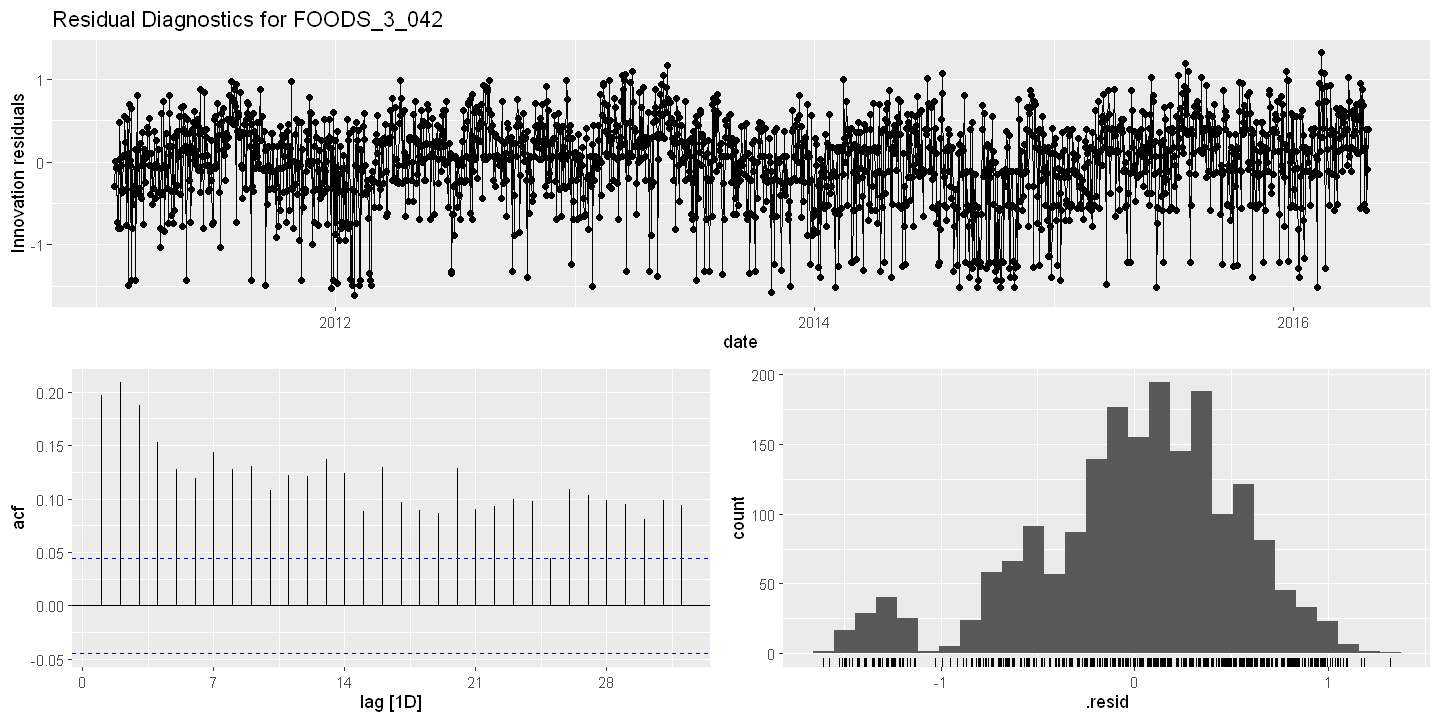

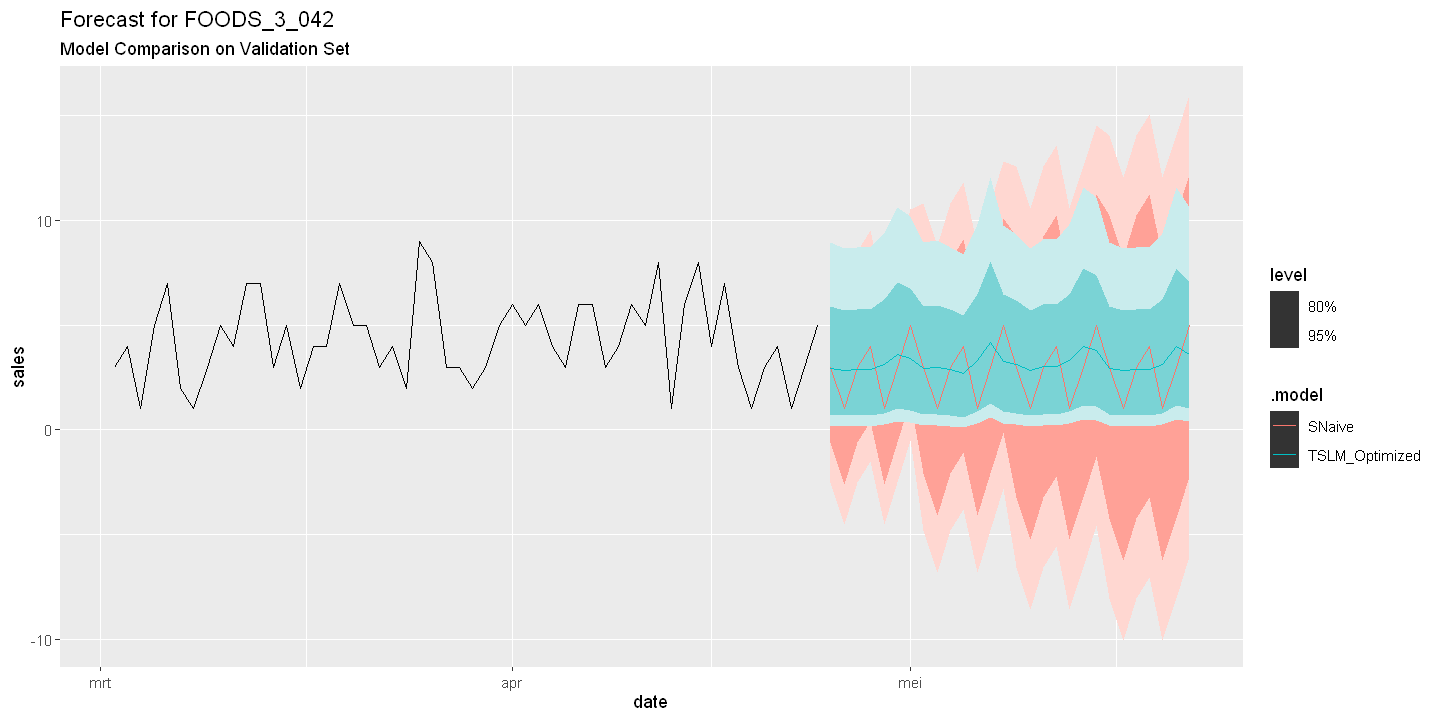

In [10]:
## Diagnostics

example_item <- unique(train_ts$item_id)[42]

coefs <- fit |>
  filter(item_id == example_item) |>
  select(TSLM_Optimized) |>
  tidy()

coefs

aug <- fit |>
  filter(item_id == example_item) |>
  select(TSLM_Optimized) |>
  augment()

features(aug, .innov, ljung_box, lag = 14)

fit |>
  filter(item_id == example_item) |>
  select(TSLM_Optimized) |>
  gg_tsresiduals() +
  labs(title = paste("Residual Diagnostics for", example_item))

fc |>
  filter(item_id == example_item) |>
  autoplot(filter(train_ts, item_id == example_item, date > ymd("2016-03-01"))) +
  labs(title = paste("Forecast for", example_item),
       subtitle = "Model Comparison on Validation Set")


  

In [11]:
#Final Evaluation on Test Set
#Load test file (d_1942 - d_1969)
eval_raw <- read_csv("sales_test_evaluation_afcs_2025.csv", show_col_types = FALSE)

#Process it using function
eval_ts <- process_data(eval_raw, calendar, prices_raw)

# Forecast on eval set
fc_eval_all <- fit |>
  forecast(new_data = eval_ts)

# Calculate RMSE per model
final_accuracy <- fc_eval_all |>
  accuracy(eval_ts) |>
  group_by(.model) |>
  summarise(RMSE = mean(RMSE, na.rm = TRUE)) |>
  arrange(RMSE)

print("Test set accuracy:")
print(final_accuracy)

Warning message:
"There were 179 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TSLM_Optimized = (function (object, ...) ...`.
Caused by warning:
! prediction from a rank-deficient fit may be misleading
ℹ Run `dplyr::last_dplyr_warnings()` to see the 178 remaining warnings."


[1] "Test set accuracy:"
# A tibble: 2 × 2
  .model          RMSE
  <chr>          <dbl>
1 TSLM_Optimized  2.16
2 SNaive          2.65


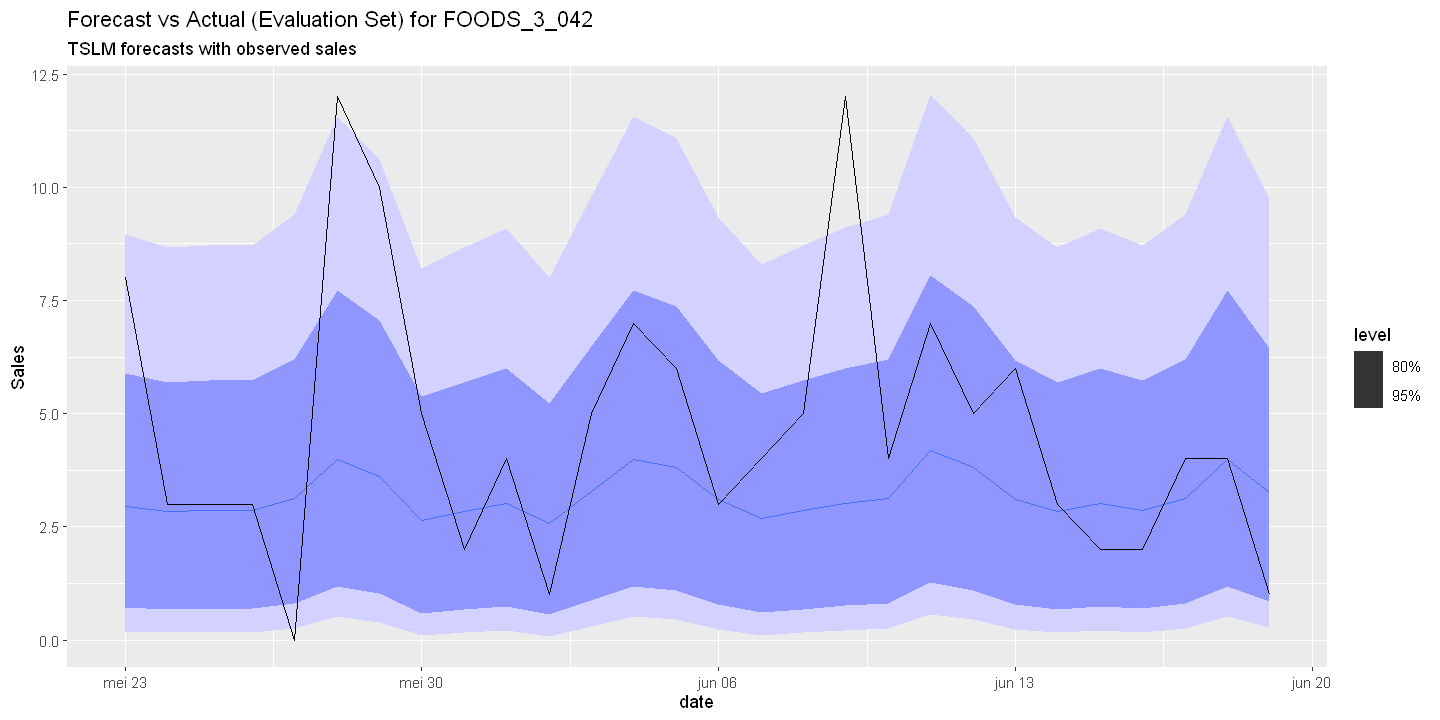

In [12]:
example_item <- unique(train_ts$item_id)[42]
fc_eval_all |>
  filter(item_id == example_item, .model == "TSLM_Optimized") |>
  autoplot(
    eval_ts |>
      filter(item_id == example_item)
  ) +
  labs(
    title = paste("Forecast vs Actual (Evaluation Set) for", example_item),
    subtitle = "TSLM forecasts with observed sales",
    y = "Sales"
  )

In [13]:
#Ljung-Box Test on all 823 items

# Calc residuals for all items
aug_all <- fit |>
  select(TSLM_Optimized) |>
  augment()

# Compute the test statistic for each item
lb_results <- aug_all |>
  features(.innov, ljung_box, lag = 14)

# 3. Calculate global summary
lb_summary <- lb_results |>
  summarise(
    Average_Stat = mean(lb_stat, na.rm = TRUE),
    Average_P_Value = mean(lb_pvalue, na.rm = TRUE),
    # Count how many items actually pass the test (p > 0.05)
    Items_Passing = sum(lb_pvalue > 0.05, na.rm = TRUE)
  )

print("Res diagnostics")
print(lb_summary)

[1] "Res diagnostics"
# A tibble: 1 × 3
  Average_Stat Average_P_Value Items_Passing
         <dbl>           <dbl>         <int>
1        1710.          0.0347            64
